In [21]:
import pandas as pd
import seaborn as sns

df = sns.load_dataset("titanic")
df.head()



,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [22]:
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

In [23]:
df = df.drop(columns=["deck", "embark_town", "alive", "who", "adult_male", "class"])


In [1]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

numeric_cols = ["age", "fare", "sibsp", "parch"]
categorical_cols = ["sex", "embarked"]


num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler())
])

 
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, numeric_cols),
    ("cat", cat_pipeline, categorical_cols)
])


In [25]:
from sklearn.model_selection import train_test_split

X = df.drop("survived", axis=1)
y = df["survived"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [26]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

def evaluate_model(model_pipeline):
    model_pipeline.fit(X_train, y_train)
    preds = model_pipeline.predict(X_test)
    probs = model_pipeline.predict_proba(X_test)[:,1]
    return {
        "accuracy": accuracy_score(y_test, preds),
        "f1":       f1_score(y_test, preds),
        "auc":      roc_auc_score(y_test, probs)
    }

models = {
    "LogisticRegression": Pipeline([("prep", preprocessor),
                                    ("clf", LogisticRegression(max_iter=1000))]),
    "KNN":                 Pipeline([("prep", preprocessor),
                                    ("clf", KNeighborsClassifier())]),
    "DecisionTree":        Pipeline([("prep", preprocessor),
                                    ("clf", DecisionTreeClassifier(random_state=42))])
}

baseline_results = {name: evaluate_model(pipe)
                    for name, pipe in models.items()}

baseline_results


{'LogisticRegression': {'accuracy': 0.7988826815642458,
  'f1': 0.71875,
  'auc': 0.8193675889328063},
 'KNN': {'accuracy': 0.8324022346368715,
  'f1': 0.7692307692307693,
  'auc': 0.8627140974967061},
 'DecisionTree': {'accuracy': 0.770949720670391,
  'f1': 0.7007299270072993,
  'auc': 0.7514492753623189}}

In [27]:
from sklearn.model_selection import GridSearchCV

param_grids = {
    "LogisticRegression": {
        "clf__C": [0.01, 0.1, 1, 10]
    },
    "KNN": {
        "clf__n_neighbors": [3, 5, 7, 9],
        "clf__weights": ["uniform", "distance"]
    },
    "DecisionTree": {
        "clf__max_depth": [None, 5, 10, 20],
        "clf__min_samples_split": [2, 5, 10]
    }
}

tuned_results = {}
for name, pipeline in models.items():
    gs = GridSearchCV(pipeline,
                      param_grids[name],
                      cv=5,
                      scoring="accuracy",
                      n_jobs=-1)
    gs.fit(X_train, y_train)
    best = gs.best_estimator_
    scores = evaluate_model(best)
    tuned_results[name] = {
        "best_params": gs.best_params_,
        **scores
    }

tuned_results


{'LogisticRegression': {'best_params': {'clf__C': 1},
  'accuracy': 0.7988826815642458,
  'f1': 0.71875,
  'auc': 0.8193675889328063},
 'KNN': {'best_params': {'clf__n_neighbors': 9, 'clf__weights': 'uniform'},
  'accuracy': 0.7821229050279329,
  'f1': 0.7111111111111111,
  'auc': 0.8381422924901186},
 'DecisionTree': {'best_params': {'clf__max_depth': 5,
   'clf__min_samples_split': 5},
  'accuracy': 0.8100558659217877,
  'f1': 0.734375,
  'auc': 0.8259552042160738}}

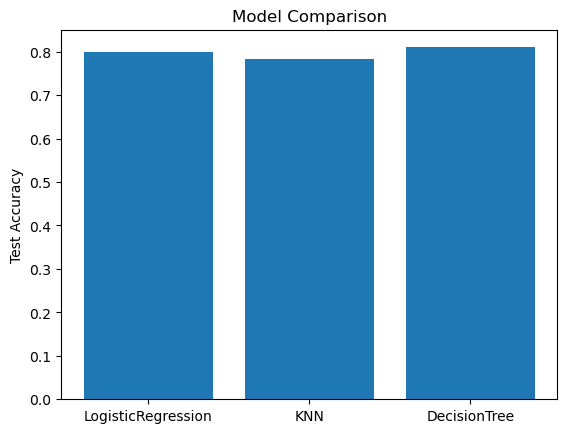

In [28]:
import matplotlib.pyplot as plt
names = list(baseline_results)
accs = [tuned_results[n]["accuracy"] for n in names]
plt.bar(names, accs)
plt.ylabel("Test Accuracy")
plt.title("Model Comparison")
plt.show()


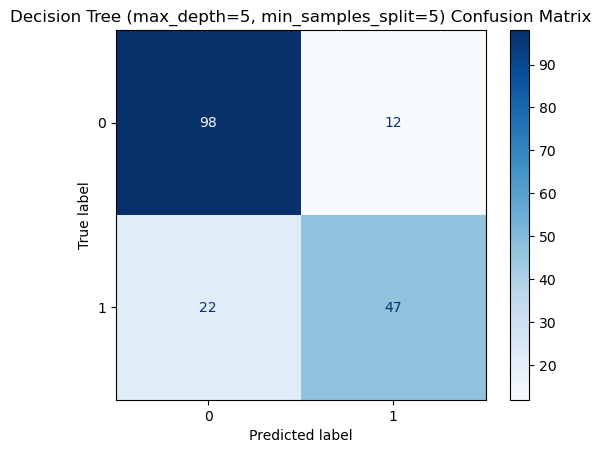

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

dt_pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", DecisionTreeClassifier(random_state=42))
])

dt_param_grid = {
    "clf__max_depth": [None, 5, 10, 20],
    "clf__min_samples_split": [2, 5, 10]
}
gs_dt = GridSearchCV(
    dt_pipe,
    dt_param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)
gs_dt.fit(X_train, y_train)


best_dt = gs_dt.best_estimator_

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = best_dt.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(cm, display_labels=best_dt.named_steps["clf"].classes_)
disp.plot(cmap="Blues")
plt.title("Decision Tree (max_depth=%s, min_samples_split=%s) Confusion Matrix"
          % (gs_dt.best_params_["clf__max_depth"],
             gs_dt.best_params_["clf__min_samples_split"]))
plt.show()
